# FloPy

FloPy has a utility for creating and managing a parent grid and a child grid.  Both grids must regular MODFLOW grids consisting of layers, rows, and columns.  The term Local Grid Refinement (LGR) is used to denote this configuration.  With the current version, only one child grid is supported; however, the utility could be used multiple times to create multiple child models.  Those child models could also be used with the utility to create grandchildren models, though it is unclear if there would be benefit to constructing models with this configuration.

The FloPy LGR utility is designed to work primarily with MODFLOW 6 as MODFLOW 6 can be used to run multiple groundwater models in the same simulation.  These models can be tightly coupled at their interfaces.  This LGR approach is based on the idea of creating multiple model instances, each with their own input and output.  This approach is different from using an unstructured grid to represent a single mesh with local refinements in areas of interest.

## Setup

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
import os
import sys
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy
from flopy.utils.lgrutil import Lgr

# temporary directory
temp_dir = TemporaryDirectory()
workspace = os.path.join(temp_dir.name, "mf6lgr")
# make sure workspace directory exists
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.2 | packaged by conda-forge | (main, Mar 31 2023, 17:45:57) [MSC v.1934 64 bit (AMD64)]
numpy version: 1.24.2
matplotlib version: 3.7.1
flopy version: 3.3.7


## LGR Utility

The LGR Utility works by defining the parent grid.  Then cells within the parent grid are marked as being replaced by a child grid with a specified level of refinement.  The terminology and variable descriptions here are based on concepts developed for the MODFLOW-LGR program.

In [2]:
# set up the parent grid information
xoffp = 0.0
yoffp = 0.0
nlayp = 3
nrowp = 25
ncolp = 45
dx = 100.0
dy = 100.0
dz = 20.0
delrp = dx * np.ones(ncolp, dtype=float)
delcp = dy * np.ones(nrowp, dtype=float)
topp = dz * np.ones((nrowp, ncolp), dtype=float)
botmp = np.empty((nlayp, nrowp, ncolp), dtype=float)
for k in range(nlayp):
    botmp[k] = -(k + 1) * dz

In [3]:
# Define relation of child to parent using
# these parent indices to show where child is active
istart = int(nrowp / 3)
istop = int(nrowp * 2 / 3) + 1
jstart = int(ncolp / 3)
jstop = int(ncolp * 2 / 3) + 1
kstart = 0
kstop = 1 + 1

# idomainp has a 1 where parent is active and 0 where child is active
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)
idomainp[kstart:kstop, istart:istop, jstart:jstop] = 0

# Set the number of child layers per parent layer (list of length parent nlay)
# The following will result in 4 child layers that span model layers
# 1 and 2 of the parent grid.  Vertical dimension of child cells will be half
# of the parent vertical dimension.
ncppl = np.array(nlayp * [2], dtype=int)
ncppl[kstop:] = 0
print(f"ncppl: {ncppl}")

# Set the number of child cells per parent cell
ncpp = 5

# Create the Lgr utility object, which contains methods for connecting a
# parent and child model in a MODFLOW 6 simulation
lgr = Lgr(
    nlayp,
    nrowp,
    ncolp,
    delrp,
    delcp,
    topp,
    botmp,
    idomainp,
    ncpp=ncpp,
    ncppl=ncppl,
    xllp=xoffp,
    yllp=yoffp,
)

ncppl: [2 2 0]


In [4]:
# information about the parent and child models
# can be accessed using simple grid objects returned
# on the fly by lgr.parent and lgr.child
print("Parent grid information")
parent = lgr.parent
print(f"parent nlay: {parent.nlay}")
print(f"parent nrow: {parent.nrow}")
print(f"parent ncol: {parent.ncol}")
print(f"parent delr[0]: {parent.delr[0]}")
print(f"parent delc[0]: {parent.delc[0]}")
print(f"parent top[0, 0]: {parent.top[0, 0]}")
print(f"parent botm[:, 0, 0]: {parent.botm[:, 0, 0]}")

print("\nChild grid information")
child = lgr.child
print(f"child nlay: {child.nlay}")
print(f"child nrow: {child.nrow}")
print(f"child ncol: {child.ncol}")
print(f"child delr[0]: {child.delr[0]}")
print(f"child delc[0]: {child.delc[0]}")
print(f"child top[0, 0]: {child.top[0, 0]}")
print(f"child botm[:, 0, 0]: {child.botm[:, 0, 0]}")

Parent grid information
parent nlay: 3
parent nrow: 25
parent ncol: 45
parent delr[0]: 100.0
parent delc[0]: 100.0
parent top[0, 0]: 20.0
parent botm[:, 0, 0]: [-20. -40. -60.]

Child grid information
child nlay: 4
child nrow: 45
child ncol: 80
child delr[0]: 20.0
child delc[0]: 20.0
child top[0, 0]: 20.0
child botm[:, 0, 0]: [  0. -20. -30. -40.]


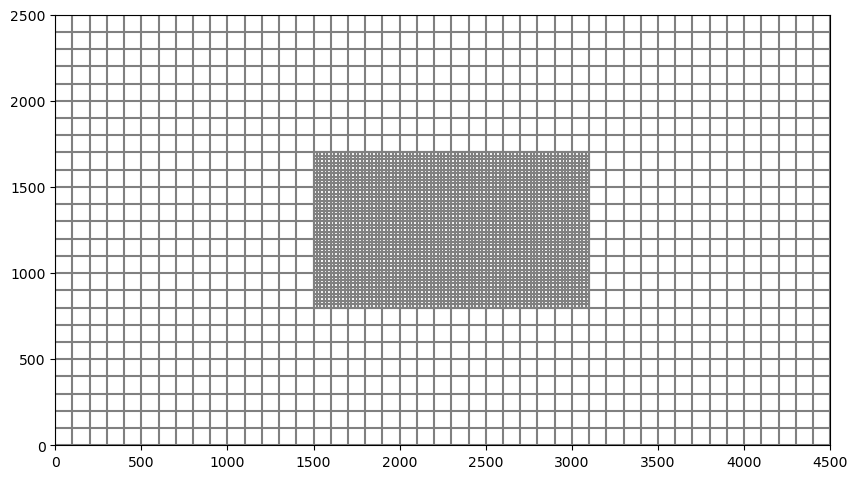

In [5]:
# from the Lgr object, it is possible to ask for a flopy modelgrid object
# for the parent and child.  These objects are created on the fly and
# can be used to plot the grids prior to creating the MODFLOW 6 simulation
mgp = lgr.parent.modelgrid
mgc = lgr.child.modelgrid

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mgc.plot(ax=ax)
mgp.plot(ax=ax)

## LGR Simple Example: Setup Grid Configuration

For this example, we reproduce the simple model shown on the front page of the flopy GitHub repository.  In this adaptation, we insert a finer, locally refined grid in the middle of the domain, but we tightly couple the parent and child models.

In [6]:
# set up the parent grid information
xoffp = 0.0
yoffp = 0.0
nlayp = 5
nrowp = 5
ncolp = 5
dx = 100.0
dy = 100.0
dz = 100.0
delrp = dx * np.ones(ncolp, dtype=float)
delcp = dy * np.ones(nrowp, dtype=float)
topp = dz * np.ones((nrowp, ncolp), dtype=float)
botmp = np.empty((nlayp, nrowp, ncolp), dtype=float)
for k in range(nlayp):
    botmp[k] = -(k + 1) * dz

# Define relation of child to parent
# idomainp has a 1 where parent is active and 0 where child is active
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)
idomainp[:, 1:4, 1:4] = 0

# Set the number of child cells per parent cell
ncpp = 5

# Set the number of child layers per parent layer (list of cell parent nlay)
ncppl = [1, 1, 1, 1, 1]

# Create the Lgr utility object, which contains methods for connecting a
# parent and child model in a MODFLOW 6 simulation
lgr = Lgr(
    nlayp,
    nrowp,
    ncolp,
    delrp,
    delcp,
    topp,
    botmp,
    idomainp,
    ncpp=ncpp,
    ncppl=ncppl,
    xllp=xoffp,
    yllp=yoffp,
)

# from the Lgr object, it is possible to ask for a flopy modelgrid object
# for the parent and child.  These objects are created on the fly and
# can be used to plot the grids prior to creating the MODFLOW 6 simulation
mgp = lgr.parent.modelgrid
mgc = lgr.child.modelgrid

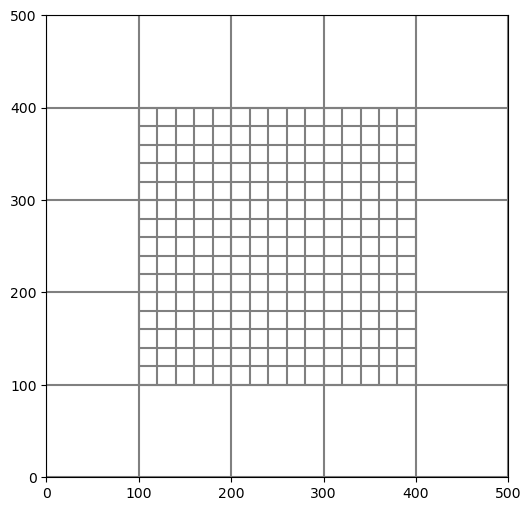

In [7]:
# plot the child and parent grids, which can be
# done easily using the flopy modelgrid objects
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mgc.plot(ax=ax)
mgp.plot(ax=ax)

### Build the MODFLOW 6 Model

 Now that we have the grid, we can setup and run the MODFLOW 6 model.

In [8]:
# set up the MODFLOW 6 simulation
ws = os.path.join(workspace, "ex1")
simname = "lgr"
pname = "parent"
cname = "child"
sim = flopy.mf6.MFSimulation(sim_name=simname, sim_ws=ws, exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim)

# Because we will use the xt3d option for coupling the models
# we need use to the asymmetric BICGSTAB linear solver
ims = flopy.mf6.ModflowIms(sim, linear_acceleration="BICGSTAB")

# retrieve the exchange data from the lgr object
exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
nexg = len(exchangedata)

# When creating the exchange, which couples the child and parent
# models, use the xt3d option, which is an alternative to the
# ghost-node correction.  This xt3d option was added as a new
# capability for the gwt-gwt and gwf-gwf exchanges in MODFLOW version 6.3.0.
exg = flopy.mf6.ModflowGwfgwf(
    sim,
    exgtype="GWF6-GWF6",
    xt3d=True,
    auxiliary=["angldegx", "cdist"],
    exgmnamea=pname,
    exgmnameb=cname,
    nexg=nexg,
    exchangedata=exchangedata,
)

# Set up the parent model and use the lgr.parent object to
# help provide the necessary information.
lgrp = lgr.parent
gwfp = flopy.mf6.ModflowGwf(sim, modelname=pname, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwfp, **lgrp.get_gridprops_dis6())
ic = flopy.mf6.ModflowGwfic(gwfp)
npf = flopy.mf6.ModflowGwfnpf(gwfp, save_specific_discharge=True)
chdspd = [[(0, 0, 0), 1.0], [(0, lgrp.nrow - 1, lgrp.ncol - 1), 0.0]]
chd = flopy.mf6.ModflowGwfchd(gwfp, stress_period_data=chdspd)
oc = flopy.mf6.ModflowGwfoc(
    gwfp,
    budget_filerecord=pname + ".bud",
    head_filerecord=pname + ".hds",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

# Set up the child model and use the lgr.child object to
# help provide the necessary information.
lgrc = lgr.child
gwfc = flopy.mf6.ModflowGwf(sim, modelname=cname, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwfc, **lgrc.get_gridprops_dis6())
ic = flopy.mf6.ModflowGwfic(gwfc)
npf = flopy.mf6.ModflowGwfnpf(gwfc, save_specific_discharge=True)
oc = flopy.mf6.ModflowGwfoc(
    gwfc,
    budget_filerecord=cname + ".bud",
    head_filerecord=cname + ".hds",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

sim.write_simulation()
success, buff = sim.run_simulation(silent=True, report=True)
if success:
    for line in buff:
        print(line)
else:
    raise ValueError("Failed to run.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package lgr.gwfgwf...
  writing model parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
  writing model child...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 05:57:01 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This s

In [9]:
# load and store the head arrays from the parent and child models
head = [gwfp.output.head().get_data(), gwfc.output.head().get_data()]

# load and store the specific discharge results for the parent and child models
bud = gwfp.output.budget()
spdis = bud.get_data(text="DATA-SPDIS")[0]
spdisp = flopy.utils.postprocessing.get_specific_discharge(spdis, gwfp)
bud = gwfc.output.budget()
spdis = bud.get_data(text="DATA-SPDIS")[0]
spdisc = flopy.utils.postprocessing.get_specific_discharge(spdis, gwfc)

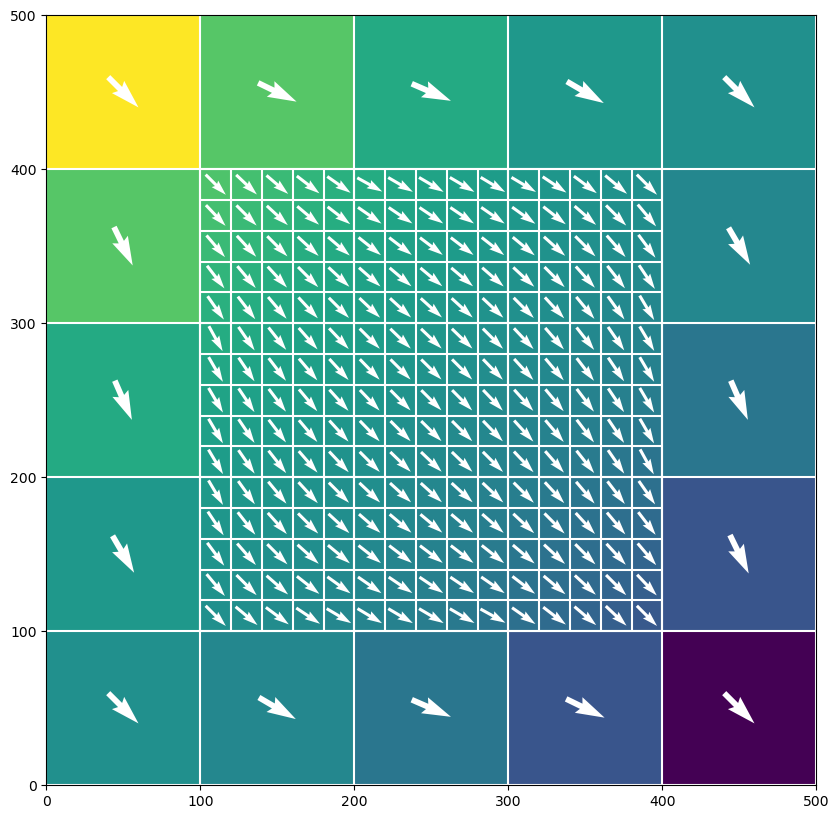

In [10]:
# plot the results from both the parent and child models
# on the same figure
f = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmvp = flopy.plot.PlotMapView(gwfp, ax=ax)
pmvc = flopy.plot.PlotMapView(gwfc, ax=ax, extent=pmvp.extent)

pmvp.plot_array(head[0], vmin=0.0, vmax=1.0)
pmvc.plot_array(head[1], vmin=0.0, vmax=1.0)

pmvp.plot_grid(colors="white")
pmvc.plot_grid(colors="white")

pmvp.plot_vector(spdisp[0], spdisp[1], normalize=True, color="white")
pmvc.plot_vector(spdisc[0], spdisc[1], normalize=True, color="white")

## LGR Flow and Transport Example: Setup Grid Configuration

For this example, we simulate coupled flow and transport for a LGR configuration.

In [11]:
# set up the parent grid information
xoffp = 0.0
yoffp = 0.0
nlayp = 3
nrowp = 25
ncolp = 45
dx = 10.0
dy = 10.0
dz = 20.0
delrp = dx * np.ones(ncolp, dtype=float)
delcp = dy * np.ones(nrowp, dtype=float)
topp = dz * np.ones((nrowp, ncolp), dtype=float)
botmp = np.empty((nlayp, nrowp, ncolp), dtype=float)
for k in range(nlayp):
    botmp[k] = -(k + 1) * dz

# Define relation of child to parent using
# these parent indices to show where child is active
istart = int(nrowp / 3)
istop = int(nrowp * 2 / 3) + 1
jstart = int(ncolp / 3)
jstop = int(ncolp * 2 / 3) + 1
kstart = 0
kstop = 1 + 1

# idomainp has a 1 where parent is active and 0 where child is active
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)
idomainp[kstart:kstop, istart:istop, jstart:jstop] = 0

# Set the number of child layers per parent layer
ncppl = np.array(nlayp * [1], dtype=int)
ncppl[kstop:] = 0
print(f"ncppl: {ncppl}")

# Set the number of child cells per parent cell
ncpp = 3

# Create the Lgr utility object, which contains methods for connecting a
# parent and child model in a MODFLOW 6 simulation
lgr = Lgr(
    nlayp,
    nrowp,
    ncolp,
    delrp,
    delcp,
    topp,
    botmp,
    idomainp,
    ncpp=ncpp,
    ncppl=ncppl,
    xllp=xoffp,
    yllp=yoffp,
)

# from the Lgr object, it is possible to ask for a flopy modelgrid object
# for the parent and child.  These objects are created on the fly and
# can be used to plot the grids prior to creating the MODFLOW 6 simulation
mgp = lgr.parent.modelgrid
mgc = lgr.child.modelgrid

ncppl: [1 1 0]


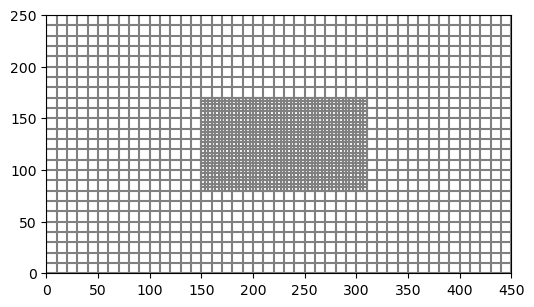

In [12]:
# plot the child and parent grids, which can be
# done easily using the flopy modelgrid objects
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mgc.plot(ax=ax)
mgp.plot(ax=ax)

### Build the MODFLOW 6 Model

 Now that we have the grid, we can setup and run the MODFLOW 6 model.

In [13]:
# set up the MODFLOW 6 simulation
ws = os.path.join(workspace, "ex2")
simname = "lgr"
sim = flopy.mf6.MFSimulation(sim_name=simname, sim_ws=ws, exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, perioddata=[(50 * 365.0, 10, 1.0)])

pname = "parent-flow"
cname = "child-flow"

# Because we will use the xt3d option for coupling the models
# we need use to the asymmetric BICGSTAB linear solver
ims_flow = flopy.mf6.ModflowIms(
    sim, linear_acceleration="BICGSTAB", filename="flow.ims"
)

# retrieve the exchange data from the lgr object
exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
nexg = len(exchangedata)

# When creating the exchange, which couples the child and parent
# models, use the xt3d option, which is an alternative to the
# ghost-node correction.  This xt3d option was added as a new
# capability for the gwt-gwt and gwf-gwf exchanges in MODFLOW version 6.3.0.
exg = flopy.mf6.ModflowGwfgwf(
    sim,
    exgtype="GWF6-GWF6",
    xt3d=True,
    auxiliary=["angldegx", "cdist"],
    exgmnamea=pname,
    exgmnameb=cname,
    nexg=nexg,
    exchangedata=exchangedata,
)

# Set up the parent model and use the lgr.parent object to
# help provide the necessary information.
lgrp = lgr.parent
gwfp = flopy.mf6.ModflowGwf(sim, modelname=pname, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwfp, **lgrp.get_gridprops_dis6())
ic = flopy.mf6.ModflowGwfic(gwfp)
npf = flopy.mf6.ModflowGwfnpf(gwfp, save_specific_discharge=True)
chdspd = [[(0, 0, 0), 1.0], [(0, lgrp.nrow - 1, lgrp.ncol - 1), 0.0]]
chd = flopy.mf6.ModflowGwfchd(gwfp, stress_period_data=chdspd)
oc = flopy.mf6.ModflowGwfoc(
    gwfp,
    budget_filerecord=pname + ".bud",
    head_filerecord=pname + ".hds",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

# Set up the child model and use the lgr.child object to
# help provide the necessary information.
lgrc = lgr.child
gwfc = flopy.mf6.ModflowGwf(sim, modelname=cname, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwfc, **lgrc.get_gridprops_dis6())
ic = flopy.mf6.ModflowGwfic(gwfc)
npf = flopy.mf6.ModflowGwfnpf(gwfc, save_specific_discharge=True)
oc = flopy.mf6.ModflowGwfoc(
    gwfc,
    budget_filerecord=cname + ".bud",
    head_filerecord=cname + ".hds",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

In [14]:
# now set up transport model
include_transport = True
if include_transport:
    pname = "parent-tran"
    cname = "child-tran"

    # retrieve the exchange data from the lgr object
    exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
    nexg = len(exchangedata)

    # When creating the exchange, which couples the child and parent
    # models, use the xt3d option, which is an alternative to the
    # ghost-node correction.  This xt3d option was added as a new
    # capability for the gwt-gwt and gwf-gwf exchanges in MODFLOW version 6.3.0.
    exg = flopy.mf6.ModflowGwtgwt(
        sim,
        exgtype="GWT6-GWT6",
        gwfmodelname1=gwfp.name,
        gwfmodelname2=gwfc.name,
        # xt3d=True,
        auxiliary=["angldegx", "cdist"],
        exgmnamea=pname,
        exgmnameb=cname,
        nexg=nexg,
        exchangedata=exchangedata,
    )

    # Set up the parent model and use the lgr.parent object to
    # help provide the necessary information.
    lgrp = lgr.parent
    gwtp = flopy.mf6.ModflowGwt(sim, modelname=pname, save_flows=True)
    dis = flopy.mf6.ModflowGwtdis(gwtp, **lgrp.get_gridprops_dis6())
    mst = flopy.mf6.ModflowGwtmst(gwtp, porosity=0.2)
    ic = flopy.mf6.ModflowGwtic(gwtp)
    adv = flopy.mf6.ModflowGwtadv(gwtp)
    dsp = flopy.mf6.ModflowGwtdsp(gwtp, alh=1.0, ath1=0.1)
    ssm = flopy.mf6.ModflowGwtssm(gwtp)
    oc = flopy.mf6.ModflowGwtoc(
        gwtp,
        budget_filerecord=pname + ".bud",
        concentration_filerecord=pname + ".ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
    )

    # Set up the child model and use the lgr.child object to
    # help provide the necessary information.
    lgrc = lgr.child
    gwtc = flopy.mf6.ModflowGwt(sim, modelname=cname, save_flows=True)
    dis = flopy.mf6.ModflowGwtdis(gwtc, **lgrc.get_gridprops_dis6())
    mst = flopy.mf6.ModflowGwtmst(gwtc, porosity=0.2)
    ic = flopy.mf6.ModflowGwtic(gwtc)
    adv = flopy.mf6.ModflowGwtadv(gwtc)
    dsp = flopy.mf6.ModflowGwtdsp(gwtc, alh=1.0, ath1=0.1)
    # ssm = flopy.mf6.ModflowGwtssm(gwtc)
    cncspd = {0: [[(0, int(lgrc.nrow / 2), int(lgrc.ncol / 2)), 1000.0]]}
    cnc = flopy.mf6.ModflowGwtcnc(gwtc, stress_period_data=cncspd)
    oc = flopy.mf6.ModflowGwtoc(
        gwtc,
        budget_filerecord=cname + ".bud",
        concentration_filerecord=cname + ".ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "ALL")],
    )

    ims_tran = flopy.mf6.ModflowIms(
        sim, linear_acceleration="BICGSTAB", filename="tran.ims"
    )
    sim.register_ims_package(ims_tran, [gwtp.name, gwtc.name])

    # couple flow and transport models
    gwfgwt_p = flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfp.name,
        exgmnameb=gwtp.name,
        filename="gwfp_gwtp.gwfgwt",
    )
    gwfgwt_c = flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfc.name,
        exgmnameb=gwtc.name,
        filename="gwfc_gwtc.gwfgwt",
    )

In [15]:
# write and run simulation
sim.write_simulation(silent=True)
success, buff = sim.run_simulation(silent=True, report=True)
assert success, "Model did not run to completion."

In [16]:
# load and store the head arrays from the parent and child models
head = [gwfp.output.head().get_data(), gwfc.output.head().get_data()]
conc = [
    gwtp.output.concentration().get_data(),
    gwtc.output.concentration().get_data(),
]

# load and store the specific discharge results for the parent and child models
bud = gwfp.output.budget()
spdis = bud.get_data(text="DATA-SPDIS")[0]
spdisp = flopy.utils.postprocessing.get_specific_discharge(spdis, gwfp)
bud = gwfc.output.budget()
spdis = bud.get_data(text="DATA-SPDIS")[0]
spdisc = flopy.utils.postprocessing.get_specific_discharge(spdis, gwfc)

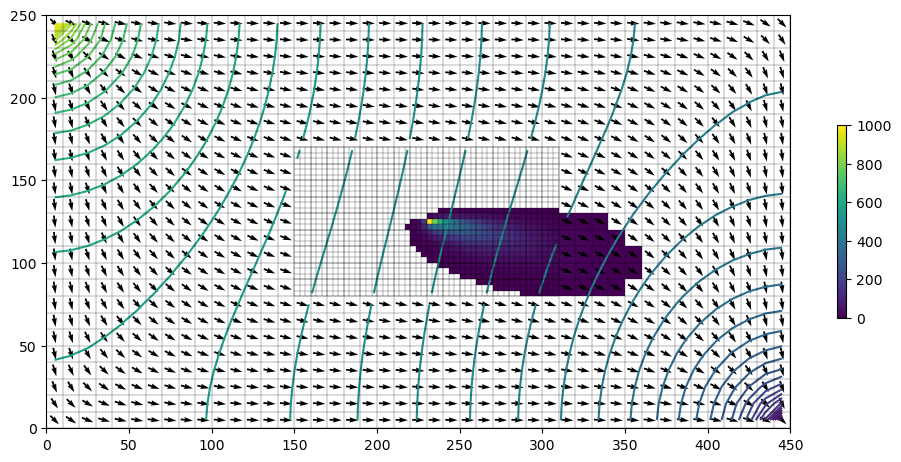

In [17]:
# plot the results from both the parent and child models
# on the same figure
f = plt.figure(figsize=(12, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmvp = flopy.plot.PlotMapView(gwfp, ax=ax)
pmvc = flopy.plot.PlotMapView(gwfc, ax=ax, extent=pmvp.extent)

# color flood head
# pmvp.plot_array(head[0], vmin=0., vmax=1., masked_values=[1.e30])
# pmvc.plot_array(head[1], vmin=0., vmax=1.)

# contour head
cs = pmvp.contour_array(head[0], levels=np.linspace(0, 1), masked_values=[1.0e30])
cs = pmvc.contour_array(head[1], levels=np.linspace(0, 1), masked_values=[1.0e30])

# color flood concentrations
a1 = conc[0]
a2 = conc[1]
a1 = np.ma.masked_where(a1 < 1.0, a1)
a2 = np.ma.masked_where(a2 < 1.0, a2)
vmin = 0.0
vmax = 1000.0
pmvp.plot_array(a1, vmin=vmin, vmax=vmax, masked_values=[1.0e30])
pa = pmvc.plot_array(a2, vmin=vmin, vmax=vmax)
plt.colorbar(pa, shrink=0.25)

# draw parent and child grids
pmvp.plot_grid(colors="black", linewidths=0.2)
pmvc.plot_grid(colors="black", linewidths=0.2)

# plot vectors
qv = pmvp.plot_vector(spdisp[0], spdisp[1], normalize=True, color="black")
# qv = pmvc.plot_vector(spdisc[0], spdisc[1], normalize=True, color="white")

In [18]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass